1. Load data
2. Tokenization

In [1]:
import pandas as pd
import re
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
#Load Data produced by Data_Wrangling notebook. 
PICKLE_LOC = "../data/dataframes/wrangled_enron_df.pkl"
enron_df = pd.read_pickle(PICKLE_LOC)

In [3]:
#Overview of the Enron dataframe. 
enron_df.head(3)

,Body,Chain,Date,Email Folder,Employee,From,Full_Email_Path,Message-ID,Signature,Subject,Extractive_Sentences,Tokenized_Body
0,"Simon, I was unable to open the attached docum...",:\tSimone La rose/ENRON@enronXgate on 05/16/20...,2001-05-17 04:18:00,sent_items,skilling-j,jeff.skilling@enron.com,../data/maildir/skilling-j/sent_items/1.,<25701656.1075840162944.JavaMail.evans@thyme>,"Thanks,\nJoannie","Re: EnronOnline Executive Summary for May 15, ...","[Simon, I was unable to open the attached docu...",[simon unable open attached document jeff skil...
1,"Erica, Due to the fact that Jeff is unable to ...","\t""'jeff.skilling@enron.com'"" <jeff.skilling@e...",2001-05-14 22:20:00,sent_items,skilling-j,jeff.skilling@enron.com,../data/maildir/skilling-j/sent_items/16.,<8541273.1075840163402.JavaMail.evans@thyme>,None,Re: Telephone Call with Jerry Murdock,"[Erica, Due to the fact that Jeff is unable to...",[erica due fact jeff unable attend july believ...
2,"PLEASE PLAN TO ATTEND ""NEW BUSINESS CREATION"" ...",None,2001-08-01 19:25:58,sent_items,skilling-j,jeff.skilling@enron.com,../data/maildir/skilling-j/sent_items/110.,<20911721.1075852686924.JavaMail.evans@thyme>,None,Please Plan to Attend,"[PLEASE PLAN TO ATTEND ""NEW BUSINESS CREATION""...",[please plan attend new business creation tues...


In [4]:
enron_df.describe()

,Body,Chain,Date,Email Folder,Employee,From,Full_Email_Path,Message-ID,Signature,Subject,Extractive_Sentences,Tokenized_Body
count,2228,586,2228,2228,2228,2228,2228,2228,298,2136,2228,2228
unique,2228,564,2215,10,1,858,2228,2228,242,1832,2228,2228
top,Dear Schwab Client: As of Thursday September 1...,"\nFrom: \tSera, Sherri On Behalf Of Skilling...",1980-01-01 00:00:00,inbox,skilling-j,sherri.sera@enron.com,../data/maildir/skilling-j/deleted_items/201.,<6365734.1075852673795.JavaMail.evans@thyme>,"Regards,\nSherri Sera\nAssistant to Jeff Skill...",Re: [smu-betas] SETI via eWooglin,[The PRELIMINARY DPR reflects a Maturity Gap R...,[preliminary dpr reflects maturity gap risk vi...
freq,1,7,4,1157,2228,169,1,1,15,17,1,1
first,NaN,NaN,1980-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2001-11-19 21:34:59,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
enron_df['Body'].isna().value_counts()

False    2228
Name: Body, dtype: int64

In [5]:
#Look at the range of dates the emails are from. 
print("Start Date: " + str(enron_df.Date.min()))
print("End Date: " + str(enron_df.Date.max()))

Start Date: 1980-01-01 00:00:00
End Date: 2001-11-19 21:34:59


In [6]:
#Creating word dictionary
freq_words = dict()

#Itereate through each tokenized sentence and split into words. Keep track of frequency in dictionary. 
for i, v in enron_df.Tokenized_Body.items():
    for sentence in v:    
        tokens = word_tokenize(sentence)
        for token in tokens:
            if token in freq_words:
                freq_words[token] += 1 
            else:
                freq_words[token] = 1

In [7]:
print('Unique words: {:,}'.format(len(freq_words)))

Unique words: 23,854


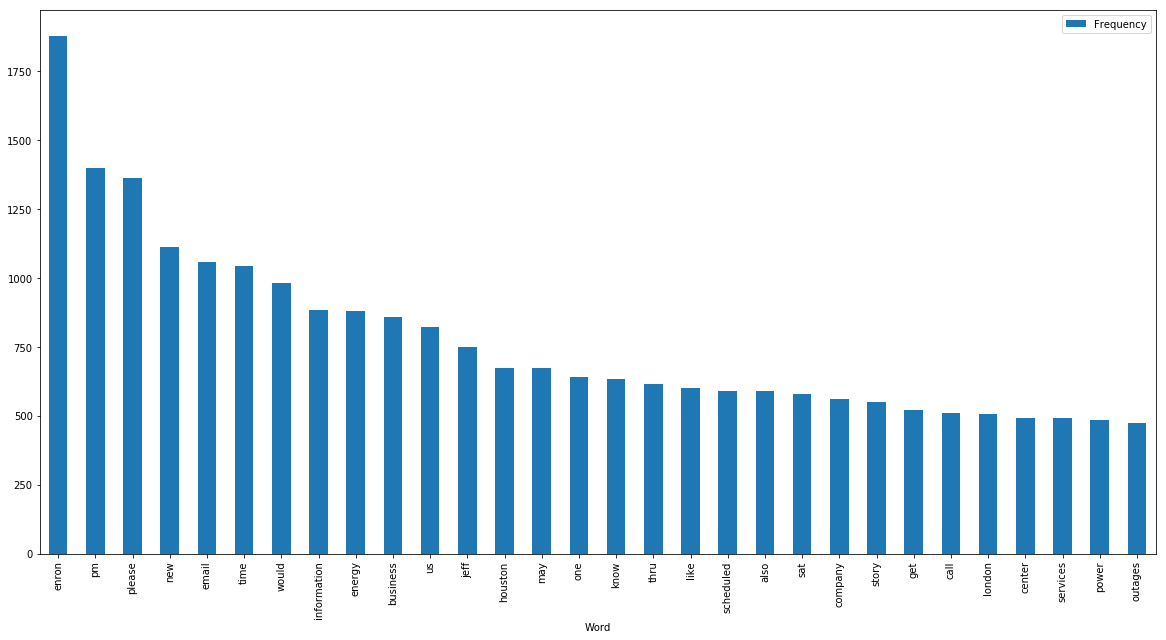

In [8]:
word_data = []
#Sort dictionary by highest word frequency. 
for key, value in sorted(freq_words.items(), key=lambda item: item[1], reverse=True):
    word_data.append([key, freq_words[key]])

#Prepare to plot bar graph of top words. 
#Create dataframe with Word and Frequency, then sort in Descending order. 
freq_words_df = pd.DataFrame.from_dict(freq_words, orient='index').reset_index()
freq_words_df = freq_words_df.rename(columns={"index": "Word", 0: "Frequency"})
freq_words_df = freq_words_df.sort_values(by=['Frequency'],ascending = False)
freq_words_df.reset_index(drop = True, inplace=True)
freq_words_df.head(30).plot(x='Word', kind='bar', figsize=(20,10))

Digging into a specific email example. 

In [9]:
email_num = 0
enron_df.iloc[email_num].Body

'Simon, I was unable to open the attached document for Jeff Skilling. Could you please resend.'

In [10]:
enron_df.iloc[email_num].Signature

'Thanks,\nJoannie'

In [11]:
enron_df.iloc[email_num].Chain

':\tSimone La rose/ENRON@enronXgate on 05/16/2001 04:52 PM\nTo:\tSunil Abraham/ENRON@enronXgate, Cliff Baxter/ENRON@enronXgate, Sally Beck/ENRON@enronXgate, Tim Belden/ENRON@enronXgate, Philippe A Bibi/ENRON@enronXgate, Raymond Bowen/ENRON@enronXgate, Debbie R Brackett/ENRON@enronXgate, William S Bradford/ENRON@enronXgate, Michael Bridges/ENRON@enronXgate, Michael R Brown/LON/ECT@ECT, Lydia Cannon/ENRON@enronXgate, Bob Crane/ENRON@enronXgate, John Cummings/ENRON@enronXgate, Bryan Deluca/ENRON@enronXgate, Karen Denne/Corp/Enron@ENRON, Jennifer deBoisblanc Denny/ENRON@enronXgate, Daniel Diamond/ENRON@enronXgate, Marc Eichmann/ENRON@enronXgate, Jim Fallon/Enron Communications@Enron Communications, Jay Fitzgerald/NY/ECT@ECT, David Forster/ENRON@enronXgate, Mark Frevert/ENRON@enronXgate, Bruce Garner/LON/ECT@ECT, Paul Goddard/EU/Enron@Enron, Joe Gold/LON/ECT@ECT, Amita Gosalia/LON/ECT@ECT, Mark E Haedicke/HOU/ECT@ECT, Jeff Harbert/ENRON@enronXgate, Greg Hermans/ENRON@enronXgate, Kimberly Hi

In [20]:
enron_df.iloc[email_num].Tokenized_Body

['simon unable open attached document jeff skilling', 'could please resend']